In [68]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, XGBClassifier
from sklearn.utils import resample
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# CAPTAIN CLEANING

In [69]:
# 1. Load & clean raw CSVs
df = pd.read_csv("Input Data.csv")
df = df[df['Row Labels'] != 'Grand Total'].copy()
df['Row Labels'] = pd.to_datetime(df['Row Labels'])
for col in ['spot_price_copkwh','electric_demand','reservoir_inflows_gwh','reservoir_gwh']:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',',''), errors='coerce')

oni = pd.read_csv("climate_change.csv")
oni_long = oni.melt(id_vars='Year', var_name='season', value_name='oni_index')

# 2. Merge ONI
season_map = {1:'NDJ',2:'DJF',3:'JFM',4:'FMA',5:'MAM',6:'AMJ',7:'MJJ',
              8:'JJA',9:'JAS',10:'ASO',11:'SON',12:'OND'}
df['season']      = df['Row Labels'].dt.month.map(season_map)
df['season_year']= np.where(df['season']=='NDJ',
                            df['Row Labels'].dt.year-1,
                            df['Row Labels'].dt.year)
df = df.merge(oni_long, left_on=['season_year','season'],
              right_on=['Year','season'], how='left').drop(columns=['Year','season_year'])
df['oni_index']   = df['oni_index'].ffill()

# 3. Create base lag features (lags 2–7) & calendar
for lag in range(2,8):
    df[f'price_lag{lag}']     = df['spot_price_copkwh'].shift(lag)
    df[f'demand_lag{lag}']    = df['electric_demand'].shift(lag)
    df[f'inflow_lag{lag}']    = df['reservoir_inflows_gwh'].shift(lag)
    df[f'reservoir_lag{lag}'] = df['reservoir_gwh'].shift(lag)
df['day_of_week'] = df['Row Labels'].dt.dayofweek
df['month']       = df['Row Labels'].dt.month

# 4. Flag spikes
threshold = df['spot_price_copkwh'].quantile(0.90)
df['is_spike']   = (df['spot_price_copkwh'] > threshold).astype(int)

# 5. Drop any rows with NaNs (from shifts) → this is your base DataFrame
df_base = df.dropna().reset_index(drop=True)

print("Preprocessing done. df_base ready with", len(df_base), "rows.")


Preprocessing done. df_base ready with 3626 rows.


# CHAT XGBOOST

In [70]:
# Prepare training and testing data (from previous steps)
X_train, y_train = train_data[feature_cols], train_data[target_col]
X_test, y_test = test_data[feature_cols], test_data[target_col]

# I adjusted max depth from 5 to 3
# Initialize XGBoost regressor with some hyperparameters
model = XGBRegressor(
    n_estimators=200,    # number of trees (boosting rounds)
    max_depth=3,         # tree depth (controls complexity)
    learning_rate=0.1,   # step size shrinkage
    subsample=0.8,       # sample fraction for each tree (to reduce overfitting)
    colsample_bytree=0.8,# feature fraction per tree
    random_state=42      # for reproducibility
)
# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the performance
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f} COP,  Test MAE: {mae:.2f} COP")

# Example: print first 5 predicted vs actual values for inspection
for actual, pred, date in zip(y_test.values[:5], y_pred[:5], test_data['Row Labels'].iloc[:5]):
    print(f"{date.date()} - Actual: {actual:.2f}, Predicted: {pred:.2f}")


Test RMSE: 95.26 COP,  Test MAE: 74.32 COP
2025-01-01 - Actual: 215.78, Predicted: 355.69
2025-01-02 - Actual: 459.57, Predicted: 234.79
2025-01-03 - Actual: 507.28, Predicted: 219.35
2025-01-04 - Actual: 415.71, Predicted: 384.52
2025-01-05 - Actual: 175.74, Predicted: 444.69


# Rolling Retraining Loop, Ensemble Classifier?

In [71]:
# -- 1. Rolling retraining for forecasting --
rolling_preds = []
rolling_true  = []
combined = pd.concat([train_df, test_df]).reset_index(drop=True)
test_start_idx = len(train_df)

for idx in range(test_start_idx, len(combined)):
    # Training history up to day idx-1
    X_hist = combined.loc[:idx-1, feature_cols]
    y_hist = combined.loc[:idx-1, target_col]
    
    # Retrain model
    model = XGBRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(
        X_hist, y_hist,
        eval_set=[(X_hist, y_hist)],
        # early_stopping_rounds=20,
        verbose=False
    )
    
    # Predict next day
    X_next = combined.loc[idx, feature_cols].values.reshape(1, -1)
    pred = model.predict(X_next)[0]
    rolling_preds.append(pred)
    rolling_true.append(combined.loc[idx, target_col])

# evaluate rolling forecast
rmse = root_mean_squared_error(rolling_true, rolling_preds)
print(f"Rolling Forecast → RMSE: {rmse:.2f} COP")


Rolling Forecast → RMSE: 70.30 COP


# Rolling & ONI

In [72]:
# Experiment: ONI lags + 7-day Rolling Averages
# 1. Fork the base DataFrame
df_exp = df_base.copy()

# 2. Compute ONI lags (30d & 60d) in the experiment frame
df_exp['oni_lag30'] = df_exp['oni_index'].shift(30)
df_exp['oni_lag60'] = df_exp['oni_index'].shift(60)

# 3. Compute 7-day rolling mean & std (shifted by 2 days)
df_exp['price_ma7']   = df_exp['spot_price_copkwh'].shift(2).rolling(7).mean()
df_exp['price_std7']  = df_exp['spot_price_copkwh'].shift(2).rolling(7).std()
df_exp['demand_ma7']  = df_exp['electric_demand'].shift(2).rolling(7).mean()
df_exp['demand_std7'] = df_exp['electric_demand'].shift(2).rolling(7).std()

# 4. Drop any rows that became NaN
df_exp = df_exp.dropna().reset_index(drop=True)

# 5. Build feature list
features = (
    [f'price_lag{i}'     for i in range(2,8)] +
    [f'demand_lag{i}'    for i in range(2,8)] +
    [f'inflow_lag{i}'    for i in range(2,8)] +
    [f'reservoir_lag{i}' for i in range(2,8)] +
    ['oni_lag30','oni_lag60','day_of_week','month'] +
    ['price_ma7','price_std7','demand_ma7','demand_std7']
)

# 6. Set up rolling forecast
train_end = pd.to_datetime("2024-12-31")
train_df  = df_exp[df_exp['Row Labels'] <= train_end]
test_df   = df_exp[df_exp['Row Labels'] >  train_end]
combined  = pd.concat([train_df, test_df]).reset_index(drop=True)
test_start = len(train_df)

preds, true_vals = [], []

for idx in range(test_start, len(combined)):
    X_hist = combined.loc[:idx-1, features]
    y_hist = combined.loc[:idx-1, 'spot_price_copkwh']
    
    model = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(
        X_hist, y_hist,
        eval_set=[(X_hist, y_hist)],
        # early_stopping_rounds=10,
        verbose=False
    )
    
    X_next = combined.loc[idx, features].values.reshape(1, -1)
    preds.append(model.predict(X_next)[0])
    true_vals.append(combined.loc[idx, 'spot_price_copkwh'])

# 7. Report RMSE
rmse = root_mean_squared_error(true_vals, preds)
print(f"ONI + Rolling Averages → RMSE: {rmse:.2f} COP")


ONI + Rolling Averages → RMSE: 73.82 COP


# Ensemble with ONI, Spike predictions, and rolling average

Spike+ONI+RollingAvg → RMSE: 74.28 COP

Feature importances:
 spike_prob        0.566008
price_lag2        0.152101
price_lag3        0.081817
price_lag4        0.041660
reservoir_lag2    0.017508
reservoir_lag3    0.016970
oni_lag60         0.015207
reservoir_lag4    0.007792
price_ma7         0.007700
inflow_lag2       0.007501
demand_ma7        0.006449
price_std7        0.006396
inflow_lag5       0.005927
demand_lag5       0.005379
demand_lag3       0.004905
demand_lag7       0.004758
oni_lag30         0.004418
reservoir_lag7    0.004364
inflow_lag6       0.003935
reservoir_lag5    0.003894
demand_lag6       0.003698
price_lag7        0.003652
demand_std7       0.003635
inflow_lag7       0.003326
inflow_lag3       0.003279
price_lag6        0.002972
price_lag5        0.002558
reservoir_lag6    0.002424
inflow_lag4       0.002403
day_of_week       0.002384
demand_lag2       0.002138
demand_lag4       0.001715
month             0.001128
dtype: float32


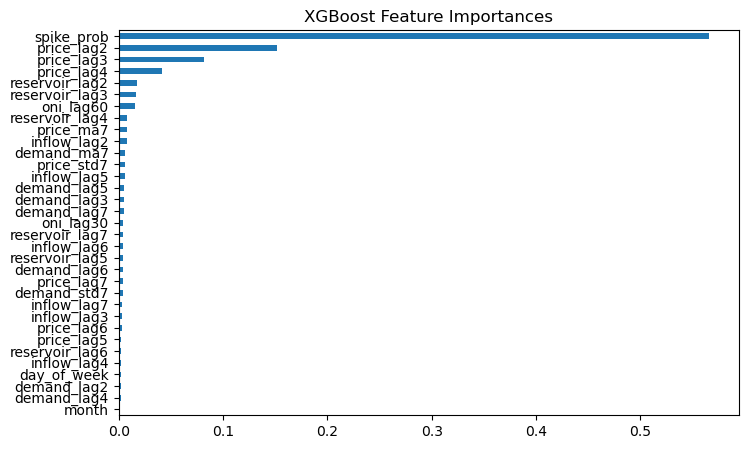

In [73]:
# 1. Fork the base DataFrame
df_exp = df_base.copy()

# 2. Compute ONI lag features
df_exp['oni_lag30'] = df_exp['oni_index'].shift(30)
df_exp['oni_lag60'] = df_exp['oni_index'].shift(60)

# 3. Compute 7-day rolling mean & std (shifted by 2 days)
df_exp['price_ma7']   = df_exp['spot_price_copkwh'].shift(2).rolling(7).mean()
df_exp['price_std7']  = df_exp['spot_price_copkwh'].shift(2).rolling(7).std()
df_exp['demand_ma7']  = df_exp['electric_demand'].shift(2).rolling(7).mean()
df_exp['demand_std7'] = df_exp['electric_demand'].shift(2).rolling(7).std()

# 4. Drop any rows that became NaN
df_exp = df_exp.dropna().reset_index(drop=True)

# 5. Train (or re-train) your spike classifiers on 2020–2024
train_end    = pd.to_datetime("2024-12-31")
train_spike  = df_exp[df_exp['Row Labels'] <= train_end]
clf_features = ['reservoir_lag2','reservoir_lag3','demand_lag2','demand_lag3','oni_lag30','oni_lag60']

# Balance the classes
maj = train_spike[train_spike['is_spike']==0]
min = train_spike[train_spike['is_spike']==1]
min_up = resample(min, replace=True, n_samples=int(len(maj)*0.5), random_state=42)
df_bal  = pd.concat([maj, min_up])
X_bal   = df_bal[clf_features]
y_bal   = df_bal['is_spike']

clf1 = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', random_state=42)
clf2 = XGBClassifier(n_estimators=100, eval_metric='logloss',
                     scale_pos_weight=(len(y_bal)-y_bal.sum())/y_bal.sum(),
                     random_state=42)
clf1.fit(X_bal, y_bal)
clf2.fit(X_bal, y_bal)

# 6. Compute spike_prob for every row
proba = (clf1.predict_proba(df_exp[clf_features])[:,1] +
         clf2.predict_proba(df_exp[clf_features])[:,1]) / 2
df_exp['spike_prob'] = proba

# 7. Define your full feature set
features = (
    [f'price_lag{i}'      for i in range(2,8)] +
    [f'demand_lag{i}'     for i in range(2,8)] +
    [f'inflow_lag{i}'     for i in range(2,8)] +
    [f'reservoir_lag{i}'  for i in range(2,8)] +
    ['oni_lag30','oni_lag60','day_of_week','month'] +
    ['price_ma7','price_std7','demand_ma7','demand_std7','spike_prob']
)

# 8. Rolling‐retrain one‐day‐ahead forecast
train_df  = df_exp[df_exp['Row Labels'] <= train_end]
test_df   = df_exp[df_exp['Row Labels'] >  train_end]
combined  = pd.concat([train_df, test_df]).reset_index(drop=True)
test_start = len(train_df)

preds, true_vals = [], []
for idx in range(test_start, len(combined)):
    X_hist = combined.loc[:idx-1, features]
    y_hist = combined.loc[:idx-1, 'spot_price_copkwh']
    model  = XGBRegressor(
        n_estimators=100, max_depth=5, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )
    model.fit(
        X_hist, y_hist,
        eval_set=[(X_hist, y_hist)],
        # early_stopping_rounds=10,
        verbose=False
    )
    X_next = combined.loc[idx, features].values.reshape(1, -1)
    preds.append(model.predict(X_next)[0])
    true_vals.append(combined.loc[idx, 'spot_price_copkwh'])

# 9. Report RMSE
rmse = root_mean_squared_error(true_vals, preds)
print(f"Spike+ONI+RollingAvg → RMSE: {rmse:.2f} COP")

# 10. Final model & feature importance
final_X = train_df[features]
final_y = train_df['spot_price_copkwh']
final_model = XGBRegressor(
    n_estimators=100, max_depth=5, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)
final_model.fit(final_X, final_y)
importances = pd.Series(final_model.feature_importances_, index=features)\
                 .sort_values(ascending=False)

print("\nFeature importances:\n", importances)
plt.figure(figsize=(8,5))
importances.plot.barh()
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importances")
plt.show()


# SuperCharge Spike Detector

In [74]:
# 1. Fork base DataFrame
df_spike = df_base.copy()

# 2. Flag spikes (top 10%)
threshold = df_spike['spot_price_copkwh'].quantile(0.90)
df_spike['is_spike'] = (df_spike['spot_price_copkwh'] > threshold).astype(int)

# 2. Compute ONI lag features
df_spike['oni_lag30'] = df_spike['oni_index'].shift(30)
df_spike['oni_lag60'] = df_spike['oni_index'].shift(60)

# 3. Prepare training data (2020–2024)
train_end = pd.to_datetime("2024-12-31")
train_data = df_spike[df_spike['Row Labels'] <= train_end]
clf_features = ['reservoir_lag2','reservoir_lag3','demand_lag2','demand_lag3','oni_lag30','oni_lag60']
X = train_data[clf_features]
y = train_data['is_spike']

# 4. Oversample minority class
maj    = train_data[y == 0]
min_cl = train_data[y == 1]
min_up = resample(min_cl, replace=True, n_samples=int(len(maj)*0.5), random_state=42)
df_bal = pd.concat([maj, min_up])
X_bal  = df_bal[clf_features]
y_bal  = df_bal['is_spike']

# 5. Train spike classifiers
clf1 = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', random_state=42)
clf2 = XGBClassifier(n_estimators=100, eval_metric='logloss',
                     scale_pos_weight=(len(y_bal)-y_bal.sum())/y_bal.sum(),
                     use_label_encoder=False, random_state=42)
clf1.fit(X_bal, y_bal)
clf2.fit(X_bal, y_bal)

# 6. Evaluate on 2025 slice
test_data = df_spike[df_spike['Row Labels'] > train_end]
X_test    = test_data[clf_features]
y_test    = test_data['is_spike']
proba     = (clf1.predict_proba(X_test)[:,1] + clf2.predict_proba(X_test)[:,1]) / 2
preds     = (proba > 0.3).astype(int)
print("Supercharged Spike Classification Report:")
print(classification_report(y_test, preds, digits=3))

Supercharged Spike Classification Report:
              precision    recall  f1-score   support

           0      0.864     0.894     0.879        85
           1      0.719     0.657     0.687        35

    accuracy                          0.825       120
   macro avg      0.791     0.776     0.783       120
weighted avg      0.821     0.825     0.823       120



/Users/gracebaker/miniconda3/envs/Colombia2/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [10:00:37] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Supercharged Spike + ONI + Rolling → RMSE: 74.25 COP

Feature importances:
 spike_prob        0.550831
price_lag2        0.161567
price_lag3        0.087730
price_lag4        0.028613
oni_lag60         0.017268
reservoir_lag2    0.015506
reservoir_lag3    0.011581
price_ma7         0.011391
reservoir_lag4    0.008088
price_std7        0.007998
inflow_lag2       0.007898
demand_lag5       0.007802
demand_lag3       0.006421
demand_std7       0.005819
reservoir_lag5    0.005795
demand_lag7       0.005256
oni_lag30         0.005100
demand_ma7        0.004775
price_lag7        0.004186
reservoir_lag6    0.004037
inflow_lag6       0.004030
demand_lag6       0.003941
inflow_lag5       0.003758
month             0.003694
reservoir_lag7    0.003673
price_lag5        0.003382
inflow_lag7       0.003331
inflow_lag3       0.003147
day_of_week       0.002886
inflow_lag4       0.002799
price_lag6        0.002681
demand_lag2       0.002677
demand_lag4       0.002339
dtype: float32


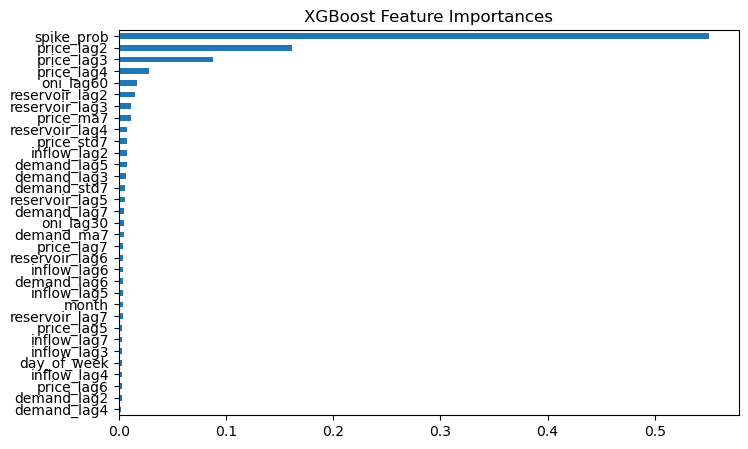

In [75]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

# 1. Fork base DataFrame
df_exp = df_base.copy()

# 2. Compute ONI lag features
df_exp['oni_lag30'] = df_exp['oni_index'].shift(30)
df_exp['oni_lag60'] = df_exp['oni_index'].shift(60)

# 3. Compute 7-day rolling statistics (shifted by 2 days)
df_exp['price_ma7']   = df_exp['spot_price_copkwh'].shift(2).rolling(7).mean()
df_exp['price_std7']  = df_exp['spot_price_copkwh'].shift(2).rolling(7).std()
df_exp['demand_ma7']  = df_exp['electric_demand'].shift(2).rolling(7).mean()
df_exp['demand_std7'] = df_exp['electric_demand'].shift(2).rolling(7).std()

# 4. Compute spike_prob using trained classifiers (from Cell 1)
clf_features = ['reservoir_lag2','reservoir_lag3','demand_lag2','demand_lag3','oni_lag30','oni_lag60']
df_exp['spike_prob'] = (clf1.predict_proba(df_exp[clf_features])[:,1] +
                        clf2.predict_proba(df_exp[clf_features])[:,1]) / 2

# 5. Drop NaNs
df_exp = df_exp.dropna().reset_index(drop=True)

# 6. Define features
features = (
    [f'price_lag{i}'     for i in range(2,8)] +
    [f'demand_lag{i}'    for i in range(2,8)] +
    [f'inflow_lag{i}'    for i in range(2,8)] +
    [f'reservoir_lag{i}' for i in range(2,8)] +
    ['day_of_week','month','oni_lag30','oni_lag60','price_ma7','price_std7','demand_ma7','demand_std7','spike_prob']
)

# 7. Rolling retrain forecast
train_end = pd.to_datetime("2024-12-31")
train_df  = df_exp[df_exp['Row Labels'] <= train_end]
test_df   = df_exp[df_exp['Row Labels'] >  train_end]
combined  = pd.concat([train_df, test_df]).reset_index(drop=True)
test_start= len(train_df)

preds, true_vals = [], []
for idx in range(test_start, len(combined)):
    X_hist = combined.loc[:idx-1, features]
    y_hist = combined.loc[:idx-1, 'spot_price_copkwh']
    model  = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05,
                         subsample=0.8, colsample_bytree=0.8, random_state=42)
    model.fit(X_hist, y_hist, eval_set=[(X_hist, y_hist)], verbose=False)
    X_next = combined.loc[idx, features].values.reshape(1,-1)
    preds.append(model.predict(X_next)[0])
    true_vals.append(combined.loc[idx, 'spot_price_copkwh'])

# 8. Report RMSE
rmse = root_mean_squared_error(true_vals, preds)
print(f"Supercharged Spike + ONI + Rolling → RMSE: {rmse:.2f} COP")

# 9. Final model & feature importances
final_X = train_df[features]
final_y = train_df['spot_price_copkwh']
final_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05,
                           subsample=0.8, colsample_bytree=0.8, random_state=42)
final_model.fit(final_X, final_y)

importances = pd.Series(final_model.feature_importances_, index=features).sort_values(ascending=False)
print("\nFeature importances:\n", importances)
plt.figure(figsize=(8,5))
importances.plot.barh()
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importances")
plt.show()


# Mixture-of-Experts: Separate Spike vs. Normal Models

In [77]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error

# 1. Fork the base DataFrame so we never clobber df_base
df_exp = df_base.copy()

# 2. (Re)compute any missing features you need in this experiment

# ONI lags
df_exp['oni_lag30'] = df_exp['oni_index'].shift(30)
df_exp['oni_lag60'] = df_exp['oni_index'].shift(60)

# Spike flag
spike_thresh = df_exp['spot_price_copkwh'].quantile(0.90)
df_exp['is_spike'] = (df_exp['spot_price_copkwh'] > spike_thresh).astype(int)

# Drop rows with NaNs from the new shifts
df_exp = df_exp.dropna().reset_index(drop=True)

# 3. Define feature lists

# features your spike classifiers expect
clf_features = ['reservoir_lag2','reservoir_lag3','demand_lag2','demand_lag3','oni_lag30','oni_lag60']

# regression features (no spike_prob here)
reg_features = (
    [f'price_lag{i}'      for i in range(2,8)] +
    [f'demand_lag{i}'     for i in range(2,8)] +
    [f'inflow_lag{i}'     for i in range(2,8)] +
    [f'reservoir_lag{i}'  for i in range(2,8)] +
    ['day_of_week','month','oni_lag30','oni_lag60']
)

# 4. Prepare for walk-forward
train_end  = pd.to_datetime("2024-12-31")
train_df   = df_exp[df_exp['Row Labels'] <= train_end]
test_df    = df_exp[df_exp['Row Labels'] >  train_end]
combined   = pd.concat([train_df, test_df]).reset_index(drop=True)
test_start = len(train_df)

preds, true_vals = [], []

# 5. Walk-forward loop
for idx in range(test_start, len(combined)):
    # a) Today’s spike probability (using your super-charged classifiers clf1 & clf2)
    today_row = combined.loc[idx, clf_features].values.reshape(1, -1)
    p_spike   = (clf1.predict_proba(today_row)[0,1] +
                 clf2.predict_proba(today_row)[0,1]) / 2

    # b) Historic data up to yesterday
    hist        = combined.loc[:idx-1]
    X_hist      = hist[reg_features]
    y_hist      = hist['spot_price_copkwh']
    spike_mask  = hist['is_spike'] == 1

    # c) Split history
    X_spike_hist = X_hist[spike_mask]
    y_spike_hist = y_hist[spike_mask]
    X_norm_hist  = X_hist[~spike_mask]
    y_norm_hist  = y_hist[~spike_mask]

    # d) Train normal‐day regressor
    norm_model = XGBRegressor(
        n_estimators=100, max_depth=5, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )
    norm_model.fit(X_norm_hist, y_norm_hist, verbose=False)

    # e) Train spike‐day regressor if enough examples
    if len(X_spike_hist) >= 5:
        spike_model = XGBRegressor(
            n_estimators=100, max_depth=3, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8, random_state=42
        )
        spike_model.fit(X_spike_hist, y_spike_hist, verbose=False)
    else:
        spike_model = norm_model

    # f) Predict
    X_next = combined.loc[idx, reg_features].values.reshape(1, -1)
    pred   = spike_model.predict(X_next)[0] if p_spike > 0.5 else norm_model.predict(X_next)[0]

    preds.append(pred)
    true_vals.append(combined.loc[idx, 'spot_price_copkwh'])

# 6. Final RMSE
rmse = root_mean_squared_error(true_vals, preds)
print(f"Mixture-of-Experts Rolling RMSE: {rmse:.2f} COP")


/Users/gracebaker/miniconda3/envs/Colombia2/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/gracebaker/miniconda3/envs/Colombia2/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/gracebaker/miniconda3/envs/Colombia2/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/gracebaker/miniconda3/envs/Colombia2/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/gracebaker/miniconda3/envs/Colombia2/lib/python3.13/site-packages/skl

Mixture-of-Experts Rolling RMSE: 115.20 COP
